In [10]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Input, Flatten
from keras import optimizers, initializers, regularizers, metrics
from keras import backend as K

import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

BATCH_SIZE = 256  # Big enough to measure an F1-score
# Adapt preprocessing and prefetching dynamically
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024


allegorical painting|Mannerism (Late Renaissance)


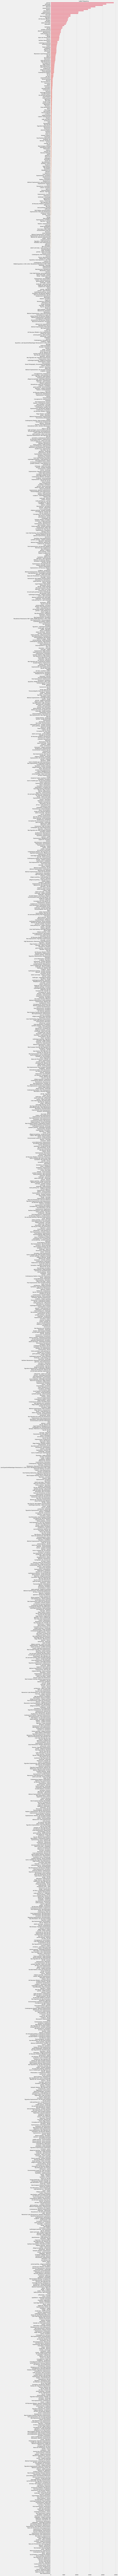

In [27]:
dir_path = './database_all'

file_list = os.listdir(dir_path)
ID = []
Labels = []

for file_name in file_list:
    string = file_name.split('+')
    if (string[0] == ''):
        continue
    ID.append(string[0])
    del string[0]
    string.pop()
    try:
        string.remove('')
    except ValueError:
        pass
    Labels.append(string)

artworks = pd.DataFrame({"ID": ID, "Labels": Labels})
artworks.dropna()
# Get label frequencies in descending order
label_freq = artworks['Labels'].apply(lambda s: ', '.join(
    x for x in s).split(', ')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12, 500))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [25]:
# Create a list of rare labels
rare = list(label_freq[label_freq < 50].index)
use = list(label_freq[label_freq >= 50].index)
print("Number of used labels:", len(use))
print("Number of ignored labels:", len(rare))
print("We will be using these rare labels:", use)


Number of used labels: 252
Number of ignored labels: 1669
We will be using these rare labels: ['portrait', 'landscape', 'genre painting', 'abstract', 'Impressionism', 'Realism', 'Romanticism', 'Expressionism', 'religious painting', 'cityscape', 'Post-Impressionism', 'figurative', 'Art Nouveau (Modern)', 'Baroque', 'Surrealism', 'sketch and study', 'illustration', '', 'Symbolism', 'still life', 'symbolic painting', 'Abstract Expressionism', 'Neoclassicism', 'nude painting (nu)', 'sculpture', 'design', 'Naïve Art (Primitivism)', 'Rococo', 'Northern Renaissance', 'marina', 'mythological painting', 'animal painting', 'Cubism', 'flower painting', 'installation', 'Abstract Art', 'self-portrait', 'photo', 'Mannerism (Late Renaissance)', 'Pop Art', 'Ukiyo-e', 'Art Informel', 'Minimalism', 'Early Renaissance', 'High Renaissance', 'Conceptual Art', 'Magic Realism', 'Neo-Expressionism', 'Color Field Painting', 'Academicism', 'allegorical painting', 'history painting', 'Contemporary Realism', 'int

In [ ]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    

In [ ]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)


In [ ]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv_layer_1(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

def conv_layer_2(x):
    x = MaxPooling2D((3, 3), 2)(x)
    shortcut = x

    for i in range(3):
        if (i == 0):
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x
        
    return x

def conv_layer_3(x):
    for i in range (4):
        if (i == 0):
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x

    return x

def conv_layer_4(x):
    for i in range(6):
        if (i == 0):
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x
    
    return x

def conv_layer_5(x):
    for i in range(3):
        if (i == 0):
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')
        x = BatchNormalization()(x)
        
        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x
    
    return x

x = conv_layer_1(input_tensor)
x = conv_layer_2(x)
x = conv_layer_3(x)
x = conv_layer_4(x)
x = conv_layer_5(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)



